In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "old_experiment_iso_195"
    npy_file_name_aniso = f"old_experiemnt_data_kT195.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The old_experiment_iso_195 data size is: (41, 500, 500, 50)
READING DATA DONE


In [3]:
step_1000grains = 44
grain_num_experiment = [5400, 3570]
grain_counts = np.array([len(np.unique(npy_file_aniso[i, :])) for i in range(npy_file_aniso.shape[0])])

closest_time_steps = np.zeros(len(grain_num_experiment))
for index, target in enumerate(grain_num_experiment):
    differences = np.abs(grain_counts - target)
    closest_index = np.argmin(differences)
    closest_time_steps[index] = closest_index

# Output the results
for index, step in enumerate(closest_time_steps):
    print(f"Closest to grain number {grain_num_experiment[index]} is at time step {step} with grain count {grain_counts[int(step)]}.")

Closest to grain number 5400 is at time step 0.0 with grain count 5464.
Closest to grain number 3570 is at time step 1.0 with grain count 3571.


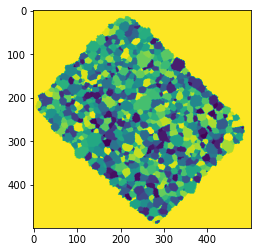

In [4]:
plt.imshow(npy_file_aniso[0,:,:,25])

## Load data

In [5]:
GB_information_name = "extracted_GB_information.npz"

loaded_data = np.load(GB_information_name)
print("\nVerifying NPZ file content:")
print(f"Keys in the NPZ file: {list(loaded_data.keys())}")
loaded_GB_id_center = loaded_data['GB_id_center']
loaded_GB_id_neighbor = loaded_data['GB_id_neighbor']
loaded_experiment_curvature = loaded_data['Experiment_Curvature']
loaded_experiment_velocity = loaded_data['Experiment_Velocity']
loaded_simulation_velocity = loaded_data['Simulation_Velocity']

loaded_GB_information = {}
for i in range(len(loaded_GB_id_center)):
    pair_id = post_processing.get_line(loaded_GB_id_center[i], loaded_GB_id_neighbor[i]) # get pair id
    if pair_id not in loaded_GB_information:
        GB_information_one_pair = np.zeros(5)
        GB_information_one_pair[:2] = sorted([loaded_GB_id_center[i], loaded_GB_id_neighbor[i]])
        if loaded_GB_id_center[i] != GB_information_one_pair[0]: continue # only store the data with small id at front 
        GB_information_one_pair[2] = loaded_experiment_curvature[i]
        GB_information_one_pair[3] = loaded_experiment_velocity[i]
        GB_information_one_pair[4] = loaded_simulation_velocity[i]
        loaded_GB_information[pair_id] = GB_information_one_pair
    else:
        if abs(abs(loaded_GB_information[pair_id][2]) - abs(loaded_experiment_curvature[i])) > 1e-10:
            print(f"Wrong consideration: waiting data ({loaded_GB_id_center[i]}, {loaded_GB_id_neighbor[i]}), in-site data ({loaded_GB_information[pair_id][:2]})")

print(f"The original length is {len(loaded_simulation_velocity)}")
print(f"The length is {len(loaded_GB_information)}")


Verifying NPZ file content:
Keys in the NPZ file: ['GB_id_center', 'GB_id_neighbor', 'Experiment_Curvature', 'Experiment_Velocity', 'Simulation_Velocity']
The original length is 5048
The length is 2524


## Get GB information

In [32]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(np.array(closest_time_steps).astype(int)):
        data_file_name = f"GB_velocity_data/3D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/3D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"].item()
                curvature_matrix_list.append(curvature_matrix)
            else:
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
                curvature_matrix_list.append(curvature_matrix)
            print("Finish curvature calculation")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id not in curvature_matrix: continue
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                        GB_infomation_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    
                    # calculate or extract curvature
                    GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

  0%|          | 0/2 [00:00<?, ?it/s]

Finish curvature calculation


 50%|█████     | 1/2 [02:45<02:45, 165.09s/it]

Current GBs len at 0 steps: 32071
Finish curvature calculation


100%|██████████| 2/2 [05:23<00:00, 161.52s/it]

Current GBs len at 1 steps: 21647


## Calculate GB difference between steps

In [33]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info_split(key,time_interval,
                                    GB_infomation_dict_list_one_step_one_key,
                                    npy_file_aniso_current,
                                    npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,
            "dV_direction2": dV_direction2,
            "current_curvature_value": current_curvature_value,
            "current_eng": 1,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    def Get_GB_movement_information(GB_infomation_dict_list_step_current, 
                                    GB_infomation_dict_list_step_next, 
                                    microstructure_current,
                                    microstructure_next,
                                    area_limit, 
                                    curvature_limit, 
                                    time_interval):

        # filter the GB between the two steps
        GB_infomation_dict_list_step_current_filtered = {}
        for key in GB_infomation_dict_list_step_current:
            # We don't consider area limit and curvature limit for this case
            if GB_infomation_dict_list_step_next.get(key) is None: 
                continue
            # if (GB_infomation_dict_list_step_current[key][5] < area_limit or 
            #     GB_infomation_dict_list_step_next.get(key) is None or 
            #     abs(GB_infomation_dict_list_step_current[key][4]) < curvature_limit): 
            #     continue
            GB_infomation_dict_list_step_current_filtered[key] = GB_infomation_dict_list_step_current[key]

        print(f"key num end with {len(GB_infomation_dict_list_step_current_filtered)}")

        dV_info_dict = {}
        for key in tqdm(GB_infomation_dict_list_step_current_filtered):
            result = compute_necessary_info_split(key,
                                                  time_interval,
                                                  GB_infomation_dict_list_step_current_filtered[key],
                                                  microstructure_current,
                                                  microstructure_next)
            dV_info_dict[key] = result

        return dV_info_dict
    
    time_interval = 2
    curvature_limit = 0.00794
    area_limit = 100
    # curvature_limit = 0
    # area_limit = 0
    
    
    # Get information between two steps
    time_first, time_next = np.array(closest_time_steps).astype(int)
    real_time_interval = (time_next - time_first) * time_interval
        
    # Stere information
    if area_limit != 100:
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_areaLimit{area_limit}_specificStep_{time_first}_{time_next}_kt1.95.npz"
    else:
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_specificStep_{time_first}_{time_next}_kt1.95.npz"
        
    if os.path.exists(data_file_folder + dV_dict_file_name):
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
    else:
        dV_dict_tmp = Get_GB_movement_information(GB_infomation_dict_list[0], 
                                                GB_infomation_dict_list[1],
                                                npy_file_aniso[time_first],
                                                npy_file_aniso[time_next],
                                                area_limit,
                                                curvature_limit,
                                                real_time_interval)
        # np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)



key num end with 17942


100%|██████████| 17942/17942 [04:56<00:00, 60.52it/s]


In [34]:
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()

    # anti_c GBs grabing
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    
    # norn_c GBs grabing
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []

    # read the info data
    print(f"Between {time_first} and {time_next}, discussed GBs is {len(dV_dict_tmp)}")
    print(f"The real GB discussed from vivek result is {len(loaded_GB_information)}")

    for key in dV_dict_tmp:
        if key not in loaded_GB_information: continue
        result = dV_dict_tmp[key]
        velocity = result["velocity"]
        current_curvature_value = result["current_curvature_value"]
        current_area = 0.5 * GB_infomation_dict_list[0][key][0]
        dV_direction1 = result["dV_direction1"]
        dV_direction2 = result["dV_direction2"]
        
        if result["is_anti_curvature"]: 
            # change the sign of the velocity by curvature
            if current_curvature_value < 0: 
                GB_antic_list_velocity_list.append(-velocity)
                GB_antic_list_curvature_list.append(-current_curvature_value)
                GB_antic_list_dV_normD_list.append(dV_direction2)
                GB_antic_list_dV_antiD_list.append(dV_direction1)
            else: 
                GB_antic_list_velocity_list.append(velocity)
                GB_antic_list_curvature_list.append(current_curvature_value)
                GB_antic_list_dV_normD_list.append(dV_direction1)
                GB_antic_list_dV_antiD_list.append(dV_direction2)
            GB_antic_list_area_list.append(current_area)
        else:
            # change the sign of the velocity by curvature
            if current_curvature_value < 0: 
                GB_normc_list_velocity_list.append(-velocity)
                GB_normc_list_curvature_list.append(-current_curvature_value)
                GB_normc_list_dV_normD_list.append(dV_direction2)
                GB_normc_list_dV_antiD_list.append(dV_direction1)
            else: 
                GB_normc_list_velocity_list.append(velocity)
                GB_normc_list_curvature_list.append(current_curvature_value)
                GB_normc_list_dV_normD_list.append(dV_direction1)
                GB_normc_list_dV_antiD_list.append(dV_direction2)
            GB_normc_list_area_list.append(current_area)
        
    print(f"Total GBs: {len(GB_antic_list_velocity_list)+len(GB_normc_list_velocity_list)}, "
          f"anti-c GBs: {len(GB_antic_list_velocity_list)} ({len(GB_antic_list_velocity_list) / (len(GB_antic_list_velocity_list)+len(GB_normc_list_velocity_list))}), " 
          f"norm-c GBs: {len(GB_normc_list_velocity_list)} ({len(GB_normc_list_velocity_list) / (len(GB_antic_list_velocity_list)+len(GB_normc_list_velocity_list))})")

Between 0 and 1, discussed GBs is 17942
The real GB discussed from vivek result is 2524
Total GBs: 2524, anti-c GBs: 781 (0.3094294770206022), norm-c GBs: 1743 (0.6905705229793978)


In [35]:
    print("anti-c GB")
    total_GB_num = len(GB_infomation_dict_list[0])
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    print("anti-c GB in real total number")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()

anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 781
The ratio of anti-curvature GBs during whole simulations is 2.4352218515169466% in 32071 GBs
The ratio of norm-curvature GBs during whole simulations is 5.434816500888654% in 32071 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 30.94294770206022% in 2524 GBs
The ratio of norm-curvature GBs during whole simulations is 69.05705229793978% in 2524 GBs



<Figure size 432x288 with 0 Axes>

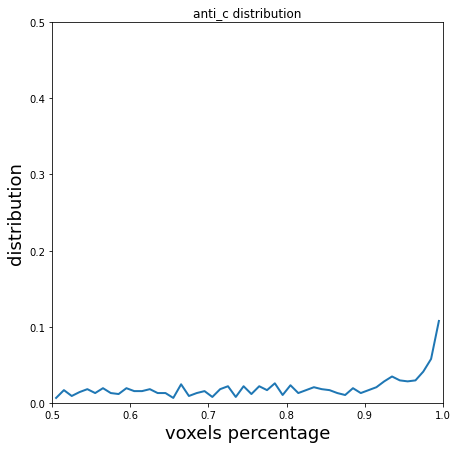

<Figure size 432x288 with 0 Axes>

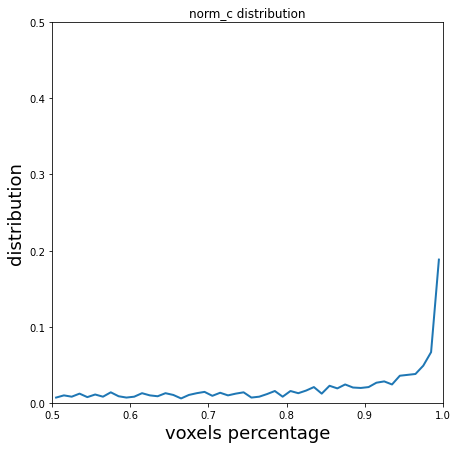

In [29]:
    # voxels information in anti-c GBs --- Yes I think it can be confidence!!!!!!
    bin_interval = 0.01
    x_lim = [0.5,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    for index in range(len(GB_antic_list_dV_normD_list)):
        antic_voxel_num_bin[int((GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    for index in range(len(GB_normc_list_dV_normD_list)):
        if GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index] == 0: continue
        normc_voxel_num_bin[int((GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    # plot
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("anti_c distribution")
    plt.plot(Antic_voxel_coordinate, antic_voxel_num_bin/np.sum(antic_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("norm_c distribution")
    plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin/np.sum(normc_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
        
    confidence_factor = 0.99
    
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    for index in range(len(GB_antic_list_velocity_list)):
        if GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
            update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
            update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
            update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
            update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
        
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    for index in range(len(GB_normc_list_velocity_list)):
        if GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index] == 0: continue
        if GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
            update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
            update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
            update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
            update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
        
            
    

In [30]:

    print("anti-c GB before removing low fraction")

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_dV_normD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(GB_antic_list_dV_normD_list)/total_GB_num_real*100}% and {len(GB_normc_list_dV_normD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("anti-c GB after removing low fraction")

    # number of GB woth high anti-c fraction (99%)
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(update_GB_antic_list_dV_antiD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 781
The ratio of anti-curvature and norm GBs during whole simulations is 30.94294770206022% and 69.05705229793978% in 2524 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 84
The ratio of anti-curvature and norm GBs during whole simulations is 3.328050713153724% and 12.916006339144214% in 2524 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) 0.26191886751270615% and 1.0164946524897882% in 32071 GBs



2.27415784926368


<Figure size 432x288 with 0 Axes>

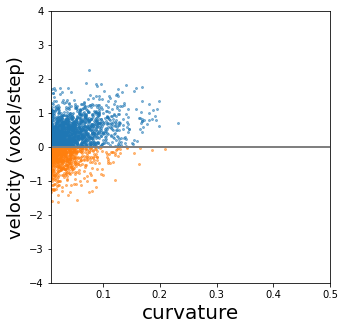

<Figure size 432x288 with 0 Axes>

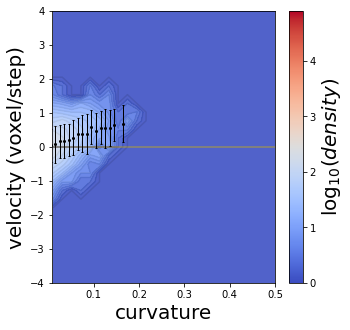

In [31]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_specificStep_{time_first}_{time_next}_kt1.95.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.8, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_curvature_list+GB_antic_list_curvature_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # bin plot
    bin_interval = 0.01
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_squared_sums = np.zeros(bin_number)

    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list

    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        if abs(curvature_val) > x_lim[1]:
            continue
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        curvature_bin_counts[bin_idx] += 1
        velocity_bin_sums[bin_idx] += velocity_val
        velocity_bin_squared_sums[bin_idx] += velocity_val ** 2

    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt((velocity_bin_squared_sums[i] / curvature_bin_counts[i]) - velocity_bin_means[i]**2)

    
    
    figure_name_all = f"figures/3D_velocity_signedcurvature_hotUpdate_{case_name}_specificStep_{time_first}_{time_next}_kt1.95.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 1
    print(np.max(np.log10(hist.T)))
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1,vmin=0,vmax=4.9)
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=0,vmax=4.9)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=4.9))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    valid_bins = curvature_bin_counts > 10
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], yerr=velocity_bin_stds[valid_bins],
             fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    


In [14]:
    time_first, time_next = np.array(closest_time_steps).astype(int)

2.110589710299249


<Figure size 432x288 with 0 Axes>

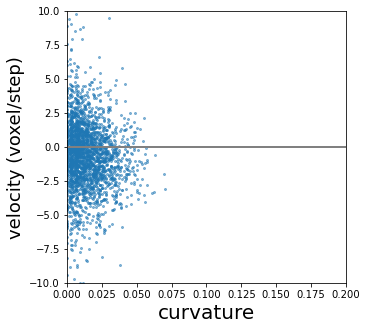

<Figure size 432x288 with 0 Axes>

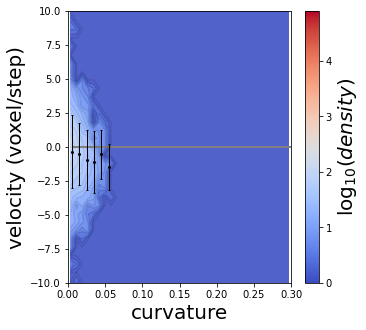

In [25]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_Experiment_velocity_signedcurvature_{case_name}_specificStep_{time_first}_{time_next}_kt1.95.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([0,0.5],[0,0],'-',color='grey',linewidth=2)
    # plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    # plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    loaded_GB_curvature = []
    loaded_GB_velocity = []
    for key in loaded_GB_information:
        if loaded_GB_information[key][2] < 0:
            loaded_GB_information[key][2] = -loaded_GB_information[key][2]
            loaded_GB_information[key][3] = -loaded_GB_information[key][3]
        loaded_GB_curvature.append(loaded_GB_information[key][2])
        loaded_GB_velocity.append(loaded_GB_information[key][3])
    plt.scatter(loaded_GB_curvature, loaded_GB_velocity,s=4,alpha=0.5)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0,0.2])
    plt.ylim([-10.0,10.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.3, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-12, 12, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(loaded_GB_curvature, loaded_GB_velocity, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # bin plot
    bin_interval = 0.01
    x_lim = [0.0,0.2]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_squared_sums = np.zeros(bin_number)

    new_curvature_1Dlist_remove_0step = loaded_GB_curvature
    new_velocity_1Dlist_remove_0step = loaded_GB_velocity

    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        if abs(curvature_val) > x_lim[1]:
            continue
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        curvature_bin_counts[bin_idx] += 1
        velocity_bin_sums[bin_idx] += velocity_val
        velocity_bin_squared_sums[bin_idx] += velocity_val ** 2

    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt((velocity_bin_squared_sums[i] / curvature_bin_counts[i]) - velocity_bin_means[i]**2)

    
    
    figure_name_all = f"figures/3D_Experiment_velocity_signedcurvature_hotUpdate_{case_name}_specificStep_{time_first}_{time_next}_kt1.95.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 1
    print(np.max(np.log10(hist.T)))
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1,vmin=0,vmax=4.9)
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=0,vmax=4.9)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=4.9))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    valid_bins = curvature_bin_counts > 10
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], yerr=velocity_bin_stds[valid_bins],
             fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([0,0.3])
    plt.ylim([-10.0,10.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    


In [29]:

    total_GB_num_real = len(loaded_GB_curvature)
    
    print("anti-c GB in real total number")
    print(f"The ratio of anti-curvature GBs during whole simulations is {np.sum(np.array(loaded_GB_velocity)<=0)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {np.sum(np.array(loaded_GB_velocity)>0)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 60.063391442155314% in 2524 GBs
The ratio of norm-curvature GBs during whole simulations is 39.936608557844686% in 2524 GBs

